In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import geopandas as gpd
from glob import glob
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [3]:
sys.path.insert(1,'../analysis/')
sys.path.insert(1,'../optimization/')

In [4]:
from results_plotting import *
import plant_optimization as pop

# Setup

## Directory Pointers

In [5]:
results_paths = '../../results/plant_optimization/final_results'

## Europe grid shapefile

In [6]:
europe_grid, europe_borders = load_base_maps()
europe_grid = europe_grid[['lat','lon','country','sea_node','geometry']]
merge_cols = list(europe_grid.columns)
merge_cols.remove('geometry')

## Results data import

In [7]:
year = '2020'
data_2020 = pd.read_csv(os.path.join(results_paths,f'{year}.csv'))
data_2020_geo = gpd.GeoDataFrame(data_2020.drop(columns=['geometry'])).merge(europe_grid,on=merge_cols,how='left')
countries = data_2020.country.unique()

/opt/anaconda3/envs/EuroSAFs/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Use the colorbar set_ticks() method instead.
/opt/anaconda3/envs/EuroSAFs/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator


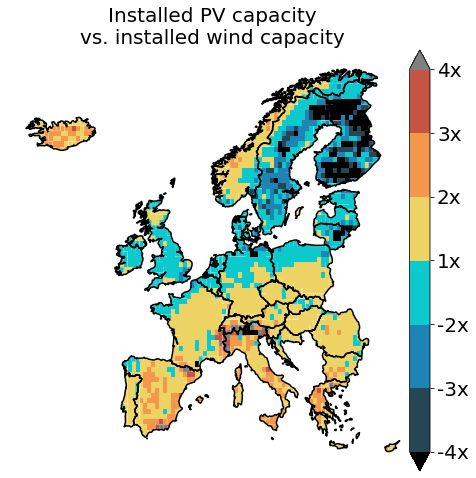

In [9]:
data = data_2020_geo.copy()
data = data.loc[data.shore_designation=='onshore']
data = data[['wind_capacity_MW','PV_capacity_MW','country','geometry','LCOF_liter']]
data['pv_vs_wind'] = np.nan
data.loc[data['wind_capacity_MW']>data['PV_capacity_MW'],'pv_vs_wind'] = -data['wind_capacity_MW']/data['PV_capacity_MW']
data.loc[data['wind_capacity_MW']<data['PV_capacity_MW'],'pv_vs_wind'] = data['PV_capacity_MW']/data['wind_capacity_MW']

# Subtract 1 from values so that they are centered around 1 instead of 0
data.loc[data['pv_vs_wind']>0,'pv_vs_wind'] = data['pv_vs_wind'] - 1
data.loc[data['pv_vs_wind']<0,'pv_vs_wind'] = data['pv_vs_wind'] + 1

metrics = {'pv_vs_wind':'Installed PV capacity\nvs. installed wind capacity'}
vmax_dict = {'pv_vs_wind':3}
vmin_dict = {'pv_vs_wind':-3}
legend_kwds = {'extend':'both','orientation':'vertical'}

colors = ['#C45544','#F4974B','#EDD363','#BEB7DF','#A4A0A9','#0BC9CD','#2A9D8F','#1D84B5','#264653']
colors = ['#C45544','#F4974B','#EDD363','#0BC9CD','#1D84B5','#264653']
colors = ['#264653', '#1D84B5', '#0BC9CD', '#EDD363', '#F4974B', '#C45544']

cmap = ListedColormap(colors)
cmap.set_over("grey")
cmap.set_under("black")
fontsize = 20

fig, axes, cb_ax = plot_results(data=data,countries=countries,metrics=metrics,
                                vmax_dict=vmax_dict,vmin_dict=vmin_dict,legend_kwds=legend_kwds,cmap=cmap,figsize=(10,10),fontsize=fontsize)

# Manually override tick labels to make them centered around 1
cb_ax.set_yticks(cb_ax.get_yticks)
cb_ax.set_yticklabels([f'{x + 1 - 2*(x<0):.0f}x' for x in cb_ax.get_yticks()]);

plt.savefig('../../gfx/pv_vs_wind.png', bbox_inches='tight', dpi=400)

/opt/anaconda3/envs/EuroSAFs/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Use the colorbar set_ticks() method instead.
/opt/anaconda3/envs/EuroSAFs/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


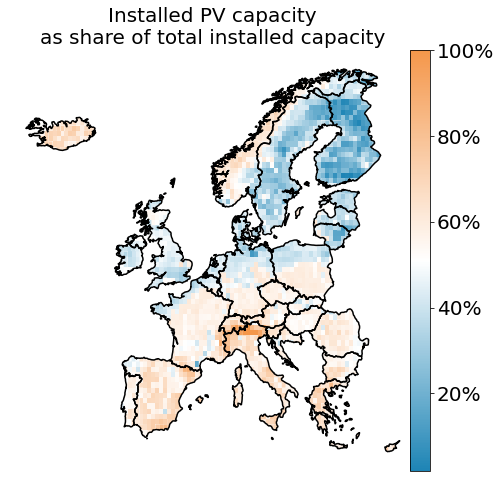

In [15]:
data = data_2020_geo.copy()
data = data.loc[data.shore_designation=='onshore']
data = data[['wind_capacity_MW','PV_capacity_MW','country','geometry','LCOF_liter']]
data['pv_share'] = data['PV_capacity_MW']/ (data['PV_capacity_MW'] + data['wind_capacity_MW'])


metrics = {'pv_share':'Installed PV capacity\nas share of total installed capacity'}

legend_kwds = {'orientation':'vertical'}


cmap = LinearSegmentedColormap.from_list('test',['#0BC9CD','lightgrey','#F4974B'])
cmap = LinearSegmentedColormap.from_list('test',['#1D84B5','white','#F4974B'])

fontsize = 20

fig, axes, cb_ax = plot_results(data=data,countries=countries,metrics=metrics,legend_kwds=legend_kwds,cmap=cmap,figsize=(10,10),fontsize=fontsize)

# Manually override tick labels to make them centered around 1
ticks = cb_ax.get_yticks()
cb_ax.set_yticks(ticks)
cb_ax.set_yticklabels([f'{x*100:.0f}%' for x in ticks]);

plt.savefig('../../gfx/pv_share_map.png', bbox_inches='tight', dpi=400)

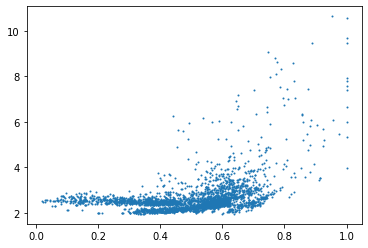

In [13]:
plt.scatter(data['pv_share'], data['LCOF_liter'], s=1)